#forecast 49

Available columns: ['date', 'index', 'store_id', 'cat_id', 'dept_id', 'item_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'qnt']


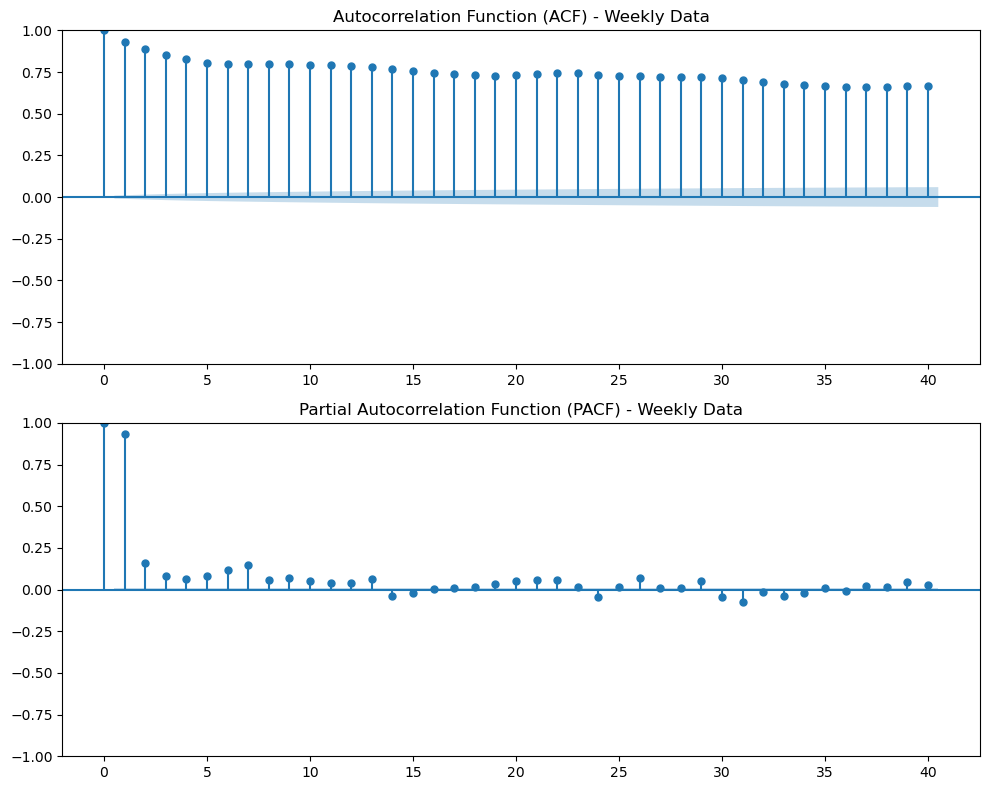

In [ ]:
# Робимо спробу підбору параметрів ACF та PACF для ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder
import holidays

# Завантажуємо дані
df = pd.read_csv('data/ts_hist.csv')

# Створимо функцію для агрегування даних за тижнями
def weekly_data_aggregation(df):
    print("Available columns:", df.columns.tolist())

    if 'date' not in df.columns:
        raise KeyError("Column 'date' not found in DataFrame")

    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Додаємо ознаку свята
    us_holidays = holidays.US()
    us_holidays = [pd.Timestamp(h) for h in us_holidays]  # Перетворюємо дати свят у Timestamp
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0) # Так, я спростив собі задачу, взявши свята не з файлу, а з бібліотеки

    # Додаємо ознаки місяця і дня тижня
    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek

    # Агрегуємо дані по тижнях
    weekly_df = df.groupby(['index', 'store_id']).resample('W').agg({
        'qnt': 'sum',
        'event_name_1': 'first',
        'event_type_1': 'first',
        'event_name_2': 'first',
        'event_type_2': 'first',
        'is_holiday': 'sum',
        'month': 'first',
        'day_of_week': 'first',
        'cat_id': 'first',  # Додаємо cat_id
        'dept_id': 'first',  # Додаємо dept_id
        'item_id': 'first'  # Додаємо item_id
    }).reset_index()

    total_sales_per_item = df.groupby('index')['qnt'].sum().reset_index(name='total_sales')
    unique_store_counts = df.groupby('index')['store_id'].nunique().reset_index(name='store_count')

    weekly_df = weekly_df.merge(unique_store_counts, on='index', how='left')
    weekly_df['avg_qnt_per_store'] = weekly_df['qnt'] / weekly_df['store_count'].replace(0, np.nan)
    weekly_df.fillna(0, inplace=True)
    weekly_df['is_holiday'] = (weekly_df['is_holiday'] > 0).astype(int)

    # Перетворюємо категоріальних змінних у числові
    le_event_type_1 = LabelEncoder()
    le_event_type_2 = LabelEncoder()
    le_cat_id = LabelEncoder()
    le_dept_id = LabelEncoder()
    le_item_id = LabelEncoder()

    weekly_df['event_type_1'] = le_event_type_1.fit_transform(weekly_df['event_type_1'].astype(str))
    weekly_df['event_type_2'] = le_event_type_2.fit_transform(weekly_df['event_type_2'].astype(str))
    weekly_df['cat_id'] = le_cat_id.fit_transform(weekly_df['cat_id'].astype(str))
    weekly_df['dept_id'] = le_dept_id.fit_transform(weekly_df['dept_id'].astype(str))
    weekly_df['item_id'] = le_item_id.fit_transform(weekly_df['item_id'].astype(str))

    weekly_df.drop(columns=['event_name_1', 'event_name_2'], inplace=True)

    return weekly_df

# Викликаємо функцію для агрегування даних по тижнях
weekly_df = weekly_data_aggregation(df)

# Визначаємо цільову змінну
time_series_data = weekly_df['qnt']

# Будуємо графіки ACF та PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(time_series_data, lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) - Weekly Data')

# PACF
plot_pacf(time_series_data, lags=40, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) - Weekly Data')

plt.tight_layout()
plt.show()

Виглядає так, що дані в нас нестаціонарні (постійно дуже високий показчик ACF). Тож, щоб досягти стаціонарності, спробуємо дані продиференціювати.

Available columns: ['date', 'index', 'store_id', 'cat_id', 'dept_id', 'item_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'qnt']


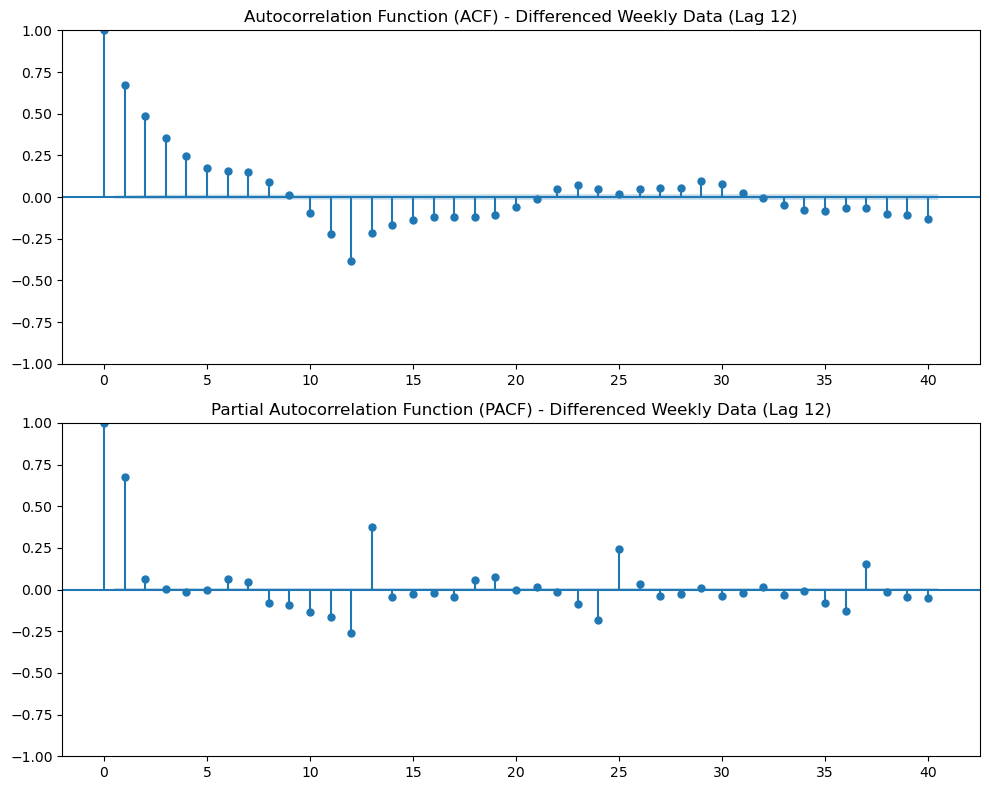

In [ ]:
# Знову робимо спробу підбору параметрів ACF та PACF для ARIMA, але тепер з диференціюванням
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder
import holidays

# Завантажуємо дані
df = pd.read_csv('data/ts_hist.csv')

# Створюємо функцію для агрегування даних за тижнями
def weekly_data_aggregation(df):
    print("Available columns:", df.columns.tolist())

    if 'date' not in df.columns:
        raise KeyError("Column 'date' not found in DataFrame")

    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Додаємо ознаку свята
    us_holidays = holidays.US()
    us_holidays = [pd.Timestamp(h) for h in us_holidays]  # Перетворюємо дати свят у Timestamp
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0) # Тут теж візьмемо не з файлу а вже з готової бібліотеки

    # Додаємо ознаки місяця і дня тижня
    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek

    # Агрегуємо дані по тижнях
    weekly_df = df.groupby(['index', 'store_id']).resample('W').agg({
        'qnt': 'sum',
        'event_name_1': 'first',
        'event_type_1': 'first',
        'event_name_2': 'first',
        'event_type_2': 'first',
        'is_holiday': 'sum',
        'month': 'first',
        'day_of_week': 'first',
        'cat_id': 'first',  # Додаємо cat_id
        'dept_id': 'first',  # Додаємо dept_id
        'item_id': 'first'  # Додаємо item_id
    }).reset_index()

    total_sales_per_item = df.groupby('index')['qnt'].sum().reset_index(name='total_sales')
    unique_store_counts = df.groupby('index')['store_id'].nunique().reset_index(name='store_count')

    weekly_df = weekly_df.merge(unique_store_counts, on='index', how='left')
    weekly_df['avg_qnt_per_store'] = weekly_df['qnt'] / weekly_df['store_count'].replace(0, np.nan)
    weekly_df.fillna(0, inplace=True)
    weekly_df['is_holiday'] = (weekly_df['is_holiday'] > 0).astype(int)

    # Перетворюємо категоріальних змінних у числові
    le_event_type_1 = LabelEncoder()
    le_event_type_2 = LabelEncoder()
    le_cat_id = LabelEncoder()
    le_dept_id = LabelEncoder()
    le_item_id = LabelEncoder()

    weekly_df['event_type_1'] = le_event_type_1.fit_transform(weekly_df['event_type_1'].astype(str))
    weekly_df['event_type_2'] = le_event_type_2.fit_transform(weekly_df['event_type_2'].astype(str))
    weekly_df['cat_id'] = le_cat_id.fit_transform(weekly_df['cat_id'].astype(str))
    weekly_df['dept_id'] = le_dept_id.fit_transform(weekly_df['dept_id'].astype(str))
    weekly_df['item_id'] = le_item_id.fit_transform(weekly_df['item_id'].astype(str))

    weekly_df.drop(columns=['event_name_1', 'event_name_2'], inplace=True)

    return weekly_df

# Викликаємо функцію для агрегування даних по тижнях
weekly_df = weekly_data_aggregation(df)

# Відокремлюємо цільову змінну в окремий набір
time_series_data = weekly_df['qnt']

# Діференціюємо наші дані з періодом 12
time_series_diff = time_series_data.diff(periods=12).dropna()

# Будуємо графіки ACF та PACF для діференційованих даних
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(time_series_diff, lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) - Differenced Weekly Data (Lag 12)')

# PACF
plot_pacf(time_series_diff, lags=40, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) - Differenced Weekly Data (Lag 12)')

plt.tight_layout()
plt.show()


А ось тут в нас можна говорити про якусь корсну для ARIMA інформацію. Тож, після деяких близьких за значенням параметрів ітерацій, я прийшов до наступного результату.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from holidays import CountryHoliday
import warnings
warnings.filterwarnings("ignore")

# Завантажуємо дані
df = pd.read_csv('data/ts_hist.csv')
df['date'] = pd.to_datetime(df['date'])

# Додаємо колонку свят (з бібліотеки)
holidays = CountryHoliday('US')
df['is_holiday'] = df['date'].apply(lambda x: 1 if x in holidays else 0)

# Створюємо функцію для агрегування даних за тижнями
def weekly_data_aggregation(df):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Агрегуємо дані по тижнях
    weekly_df = df.groupby(['index']).resample('W').agg({
        'qnt': 'sum',
        'is_holiday': 'sum'  # Сумуємо кількість свят
    }).reset_index()

    # Інтерполюємо відсутні значеня для кожного товару окремо
    weekly_df = weekly_df.set_index('date')
    weekly_df['qnt'] = weekly_df.groupby('index')['qnt'].apply(lambda x: x.interpolate(method='linear')).values
    weekly_df.reset_index(inplace=True)

    return weekly_df

# Викликаємо функцію для агрегування даних по тижнях
weekly_df = weekly_data_aggregation(df)

# Створюємо функцію для прогнозування з використанням моделі ARIMA для кожного товару
def arima_forecast(df, weeks_ahead=1):
    forecast_results = []

    # Прогноз для кожного товару
    for item in df['index'].unique():
        item_data = df[df['index'] == item].set_index('date')

        # Перевіряємо наявність значень у даних товару
        if item_data['qnt'].isnull().all():
            forecast_results.append({'index': item, 'y': np.nan})
            continue

        # Вибираємо оптимальні параметри на основі графіків ACF та PACF)
        model = ARIMA(item_data['qnt'], order=(1, 1, 1), exog=item_data['is_holiday'])  # Додаємо святкові дані
        model_fit = model.fit()

        # Отримуємо прогноз на weeks_ahead
        forecast = model_fit.forecast(steps=weeks_ahead, exog=[item_data['is_holiday'].iloc[-1]])  # Використовуємо останнє значення свят
        forecast_value = forecast[0] if len(forecast) > 0 else np.nan

        # Зберігаємо результати для кожного товару
        forecast_results.append({'index': item, 'y': int(forecast_value) if not np.isnan(forecast_value) else np.nan})

    return pd.DataFrame(forecast_results)

# Запускаємо прогнозування
forecast_df = arima_forecast(weekly_df)

# Зберігаємо результати у CSV
forecast_df.to_csv('weekly_sales_forecast.csv', index=False)
print("Файл 'weekly_sales_forecast.csv' успішно збережено.")


Файл 'weekly_sales_forecast.csv' успішно збережено.
